In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
from datetime import datetime
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data sets/data/kaggle/kaggle_visible_evaluation_triplets.txt',sep='\t',names=['user_id','song_id','freq'])
df.head()

,user_id,song_id,freq
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df.describe()

,freq
count,1.450933e+06
mean,3.187149e+00
std,7.051664e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,9.230000e+02


In [7]:
detail_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data sets/data/kaggle/unique_tracks.txt',sep='<SEP>',names = ['track_id','song_id','artist_name','release'])
detail_df.head()

,track_id,song_id,artist_name,release
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [8]:
detail_df.tail()

,track_id,song_id,artist_name,release
999995,TRYYYUS12903CD2DF0,SOTXAME12AB018F136,Kiko Navarro,O Samba Da Vida
999996,TRYYYJO128F426DA37,SOXQYIQ12A8C137FBB,Kuldeep Manak,Jago Chhadeo
999997,TRYYYMG128F4260ECA,SOHODZI12A8C137BB3,Gabriel Le Mar,Novemba
999998,TRYYYDJ128F9310A21,SOLXGOR12A81C21EB7,Elude,Faraday
999999,TRYYYVU12903CD01E3,SOWXJXQ12AB0189F43,Texta,Fernweh feat. Sektion Kuchikäschtli


In [9]:
duplicated = detail_df['song_id'].duplicated()
sum(duplicated)

944

In [10]:
detail_df.drop_duplicates(subset ="song_id",keep = False,inplace = True)

In [11]:
duplicated = detail_df['song_id'].duplicated()
sum(duplicated)

0

In [12]:
song_df = pd.merge(df,detail_df,how = "left" )
song_df.head()

,user_id,song_id,freq,track_id,artist_name,release
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Cartola,Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,Miguel Calo,El Cuatrero


## basic stats

In [13]:
print('Total data points ;', song_df.shape[0])
print('Total number of users ;', song_df['user_id'].unique().shape[0])
print('Total number of songs ;', song_df['song_id'].unique().shape[0])
print('Total number of tracks ;', song_df['track_id'].unique().shape[0])
print('Number of Unique Release ;', song_df['release'].unique().shape[0])
print('Number of Unique artists ;', song_df['artist_name'].unique().shape[0])


Total data points ; 1450933
Total number of users ; 110000
Total number of songs ; 163206
Total number of tracks ; 162620
Number of Unique Release ; 137239
Number of Unique artists ; 28338


In [14]:
song_df = song_df.drop('track_id',1)

## Distribution of Frequency

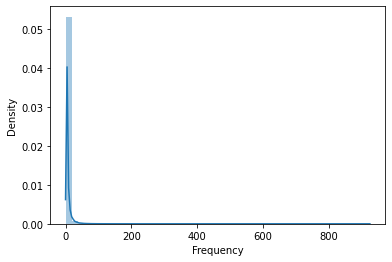

In [15]:
sns.distplot(song_df['freq'])

plt.xlabel('Frequency')
plt.ylabel('Density')
plt.show() 

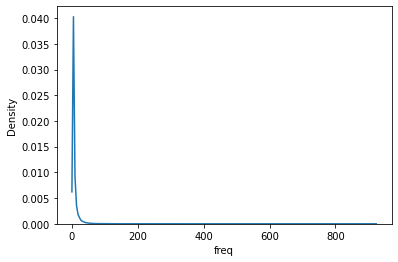

In [16]:

sns.kdeplot(data = song_df['freq']);

##  Number of songs listened per user

In [17]:
songs_per_user = song_df.groupby('user_id')['freq'].agg(['count'])


In [18]:
songs_per_user.head()

,count
user_id,
00007a02388c208ea7176479f6ae06f8224355b3,9
00014a76ed063e1a749171a253bca9d9a0ff1782,11
00015189668691680bb1a2e58afde1541ec92ced,17
0001ff7aa2667c8d8b945317b88adaed1c0b9dc2,9
00020fcd8b01986a6a85b896ccde6c49f35142ad,32


In [19]:
songs_per_user.sort_values(by = 'count').head()

,count
user_id,
336c306c5df497a9cb4067c14d5b840ba1a1e272,5
47b83637c7726c40218552445e1dc9b906f0ad6d,5
5519a61514f2248435a70afad322568c1a1173eb,5
ae7a9eaf03f35908b8ffc420241f99e9c6057bf2,5
18cb5d68334667324a9bac0a66f6579f34f43a31,5


In [20]:
songs_per_user.sort_values(by = 'count').tail()

,count
user_id,
0f8308935bcbb9a1e04ebb7c4d41c037e5f23b90,52
03ad93fdb01506ce205f4708decf8e4b1ae90fff,52
016a24e91a72c159a5048ab1b9b2ba5ce761b526,52
d30e18323f15426c3cdc8585252ed34459916f51,52
7d90be8dfdbde170f036ce8a4b915440137cb11c,53


In [21]:
songs_per_user.describe()

,count
count,110000.000000
mean,13.190300
std,8.070827
min,5.000000
25%,7.000000
50%,11.000000
75%,17.000000
max,53.000000


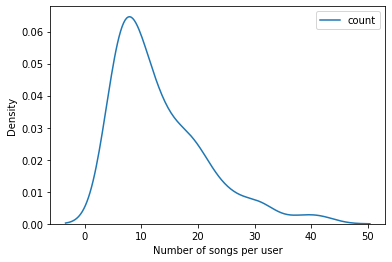

In [22]:
plt.xlabel('Number of songs per user')

sns.kdeplot(data = songs_per_user[:200])

plt.show()

## Analysis of popular artist

In [23]:
artist_popularity = song_df.groupby('artist_name')['freq'].agg(['count'])
artist_popularity.head()


,count
artist_name,
!!!,109
!Deladap,3
& And Oceans,2
'68 Comeback,22
'N Sync/Phil Collins,48


In [24]:
artist_popularity.sort_values(by='count',ascending = False).head()

,count
artist_name,
Coldplay,10883
Florence + The Machine,8213
Train,6617
The Black Keys,6507
Jack Johnson,6104


In [25]:
artist_popularity.sort_values(by='count',ascending = False).tail()

,count
artist_name,
The Brand New Heavies Feat. Sy Smith,1
The Brain Police,1
Bruce Ruffin,1
Gordon Jenkins,1
Özlem Tekin,1


In [26]:
song_df.columns

Index(['user_id', 'song_id', 'freq', 'artist_name', 'release'], dtype='object')

In [27]:
grp_by_artist = song_df.groupby('artist_name')
grp_by_artist.first()


,user_id,song_id,freq,release
artist_name,,,,
!!!,6de4f2710a3cf3138394d931215224efac265abf,SORLTDE12A6D4F5705,1,Must Be The Moon
!Deladap,d0f78656b459006aa5a78f1a58d8d5adff843a6a,SOVAYGX12A6D4F9DCC,1,Goldregen (N.O.H.A. Mix)
& And Oceans,f94b8cf37128af23239c6552f8b2e941fd1b28f4,SOQFSJI12A67ADA711,1,Odious And Devious
'68 Comeback,25e17cfe32e633d4ea276ce835b66d62a04c658d,SOMDRCR12AB018CB20,1,All Night Long
'N Sync/Phil Collins,a2becba323cdd81dc8743709825707343e84d39a,SORUSZO12AB01812C4,2,Trashin' The Camp (Phil And 'N Sync Version)
...,...,...,...,...
Étienne Daho,7a806e1b5adfb9fd4d27615724e5f80d31d1c6e5,SOLCNTW12A6D4FAD0C,5,Satori pop century (Live 1986)
Íon,86d1ca3364b66f761430a03e9b586c8c66ff4380,SOKMTEJ12AB0185DFB,10,Fé_ Esperanza_ Amor
Ólafur Arnalds,b7a856ab9b3b323fdd351b68d17ed9cdf5517dcd,SOIYAMZ12A8C1403E8,1,Þú ert jörðin


In [28]:
grp_by_artist.get_group('Coldplay')['release'].unique()

array(['The Scientist', 'Fix You', "Don't Panic", 'Sparks', 'Clocks',
       'Life In Technicolor ii', 'Such A Rush', 'Fix You (Live)',
       'Speed Of Sound', 'Lost!', 'God Put A Smile Upon Your Face',
       'Brothers & Sisters', 'A Rush Of Blood To The Head',
       'Clocks (Live In Sydney)', 'One I Love', 'For You',
       'You Only Live Twice (Live From Norway)', 'Shiver',
       'Swallowed In The Sea', 'In My Place', 'Postcards From Far Away',
       'Glass Of Water', "Things I Don't Understand", 'Strawberry Swing',
       'Til Kingdom Come', 'The Goldrush', 'X & Y', 'Life In Technicolor',
       'We Never Change', 'Bigger Stronger', 'What If', 'Trouble',
       "Everything's Not Lost (Includes Hidden Track 'Life Is For Living')",
       'Only Superstition', 'Politik', 'Careful Where You Stand',
       'Warning Sign', 'See You Soon', 'Spies', 'Cemeteries Of London',
       'A Whisper', 'A Message', 'Square One', 'Low', 'I Bloom Blaum',
       'I Ran Away', 'The World Turned Upsi

In [29]:
grp_by_artist.get_group('Justin Bieber')['release'].unique()

array(['Down To Earth', 'One Time', 'U Smile', 'Favorite Girl', 'Love Me',
       'Common Denominator', 'Never Let You Go', 'Stuck In The Moment',
       'Up', 'One Less Lonely Girl', 'That Should Be Me', 'Bigger',
       'Runaway Love'], dtype=object)

In [30]:
sorted_artist_popularity = artist_popularity.sort_values(by = 'count',ascending =False)

In [31]:
sorted_artist_popularity

,count
artist_name,
Coldplay,10883
Florence + The Machine,8213
Train,6617
The Black Keys,6507
Jack Johnson,6104
...,...
The Brand New Heavies Feat. Sy Smith,1
The Brain Police,1
Bruce Ruffin,1


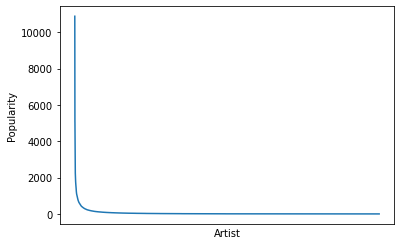

In [32]:
sorted_artist_popularity['count'].plot();
plt.xlabel('Artist')
plt.ylabel('Popularity')
plt.xticks([]);



## Analysis of popularity of song

In [33]:
song_popularity = song_df.groupby('release')['freq'].agg(['count'])


In [34]:
song_popularity.head()

,count
release,
Ef Ég Hefði Aldrei...,1
Light Mass Prayers,4
"The Arsonist Story"": Evil Craves Attention/Our Son/10x10",1
Ég Átti Gráa Æsku,4
(Jack The Stripper),2


In [35]:
song_popularity.sort_values(by = 'count').head()

,count
release,
Ef Ég Hefði Aldrei...,1
Malade Imaginaire Intro,1
Malade Imaginaire,1
Malabares,1
Mala morska vila,1


In [36]:
song_popularity.sort_values(by = 'count').tail()

,count
release,
Revelry,3672
Dog Days Are Over (Radio Edit),3780
You're The One,4270
Undo,4483
Sehr kosmisch,5043


In [37]:
song_popularity.sort_values(by = 'count', ascending = False).head()

,count
release,
Sehr kosmisch,5043
Undo,4483
You're The One,4270
Dog Days Are Over (Radio Edit),3780
Revelry,3672


In [38]:
sorted_song_popularity = song_popularity.sort_values(by = 'count', ascending = False)

In [39]:
sorted_song_popularity

,count
release,
Sehr kosmisch,5043
Undo,4483
You're The One,4270
Dog Days Are Over (Radio Edit),3780
Revelry,3672
...,...
Lo Que No Sabes,1
Lo Que La Vida Te Dá,1
Lo Que Dicte El Corazón,1


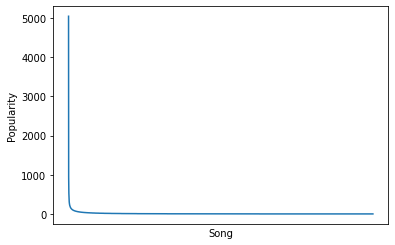

In [40]:
sorted_song_popularity['count'].plot();
plt.xlabel('Song')
plt.ylabel('Popularity')
plt.xticks([]);


In [41]:
# alternative method

song_df[song_df['artist_name'] == 'Justin Bieber']['release'].unique()

array(['Down To Earth', 'One Time', 'U Smile', 'Favorite Girl', 'Love Me',
       'Common Denominator', 'Never Let You Go', 'Stuck In The Moment',
       'Up', 'One Less Lonely Girl', 'That Should Be Me', 'Bigger',
       'Runaway Love'], dtype=object)

## Univariate Analysis

### Top 5 songs

In [42]:
top_5_songs = song_popularity.sort_values(by = 'count', ascending = False).head()

Text(0, 0.5, 'frequency')

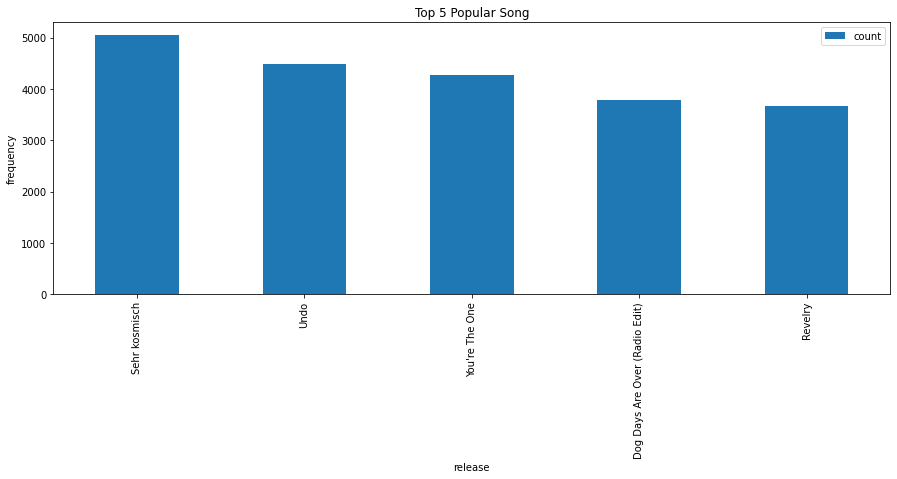

In [43]:
top_5_songs.plot(kind='bar', figsize=(15,5));
plt.title("Top 5 Popular Song")
plt.ylabel('frequency')

In [44]:
top_5_songs

,count
release,
Sehr kosmisch,5043
Undo,4483
You're The One,4270
Dog Days Are Over (Radio Edit),3780
Revelry,3672


In [45]:
song_df[song_df['release'] == 'Sehr kosmisch']['artist_name'].unique()

array(['Harmonia'], dtype=object)

In [46]:
list =  ['Sehr kosmisch','Undo',"You're The One",'Dog Days Are Over (Radio Edit)','Revelry']
for i in list:
    print(song_df[song_df['release'] == i]['artist_name'].unique())

['Harmonia']
['Björk']
['Dwight Yoakam' 'The Black Keys' 'Cece Winans' 'SWV'
 'Blood_ Sweat & Tears' 'Guerilla Black featuring Mario Winans'
 'Sugarcult' 'Shane MacGowan And The Popes' 'The Vogues' 'Natalie'
 'Brown Boy' 'Clannad' 'Buddy Holly' 'Spoken']
['Florence + The Machine']
['Kings Of Leon']


In [47]:
song_df[song_df['release'] == "You're The One"]['artist_name'].nunique()

14

In [48]:
top_artist = sorted_artist_popularity.head()

In [49]:
top_artist

,count
artist_name,
Coldplay,10883
Florence + The Machine,8213
Train,6617
The Black Keys,6507
Jack Johnson,6104


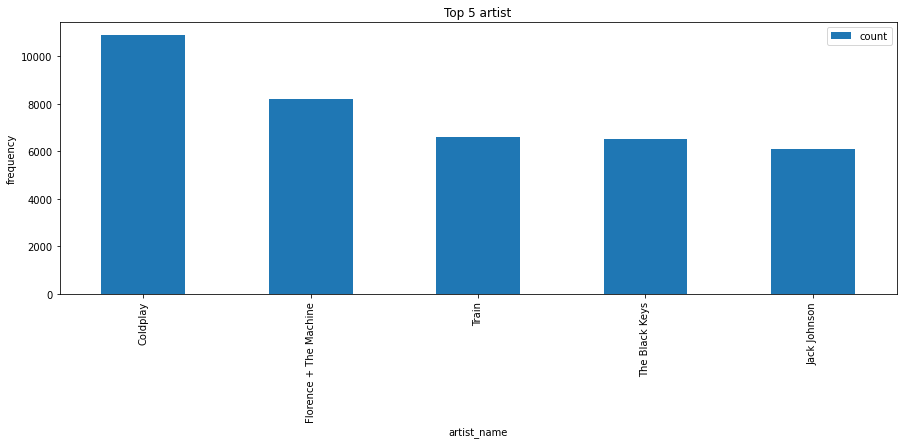

In [50]:
top_artist.plot(kind='bar', figsize=(15,5));
plt.title("Top 5 artist")
plt.ylabel('frequency');

In [51]:
music_lovers = songs_per_user.sort_values(by = 'count', ascending = False).head(20)

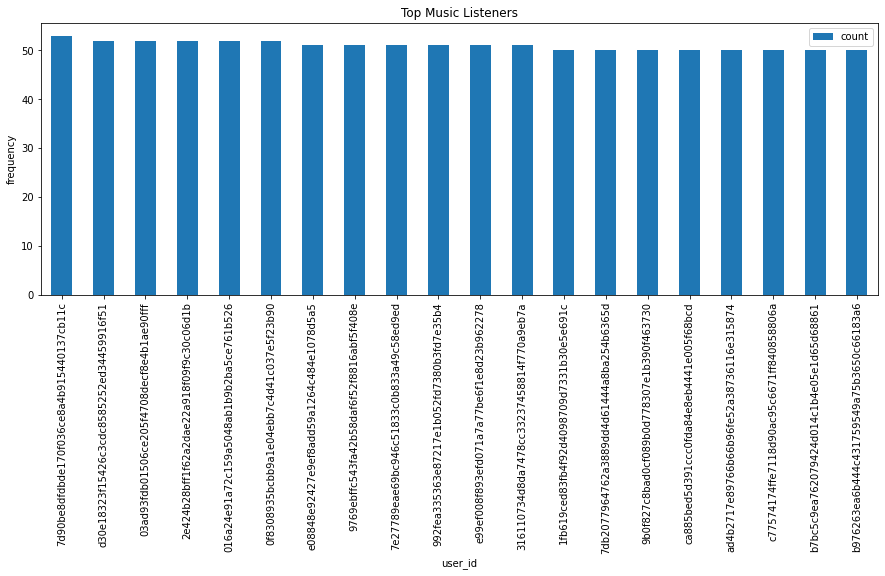

In [52]:
music_lovers.plot(kind='bar', figsize=(15,5));
plt.title("Top Music Listeners")
plt.ylabel('frequency');

In [53]:
top_5_songs.shape

(5, 1)

In [54]:
top_5_songs_artist = ['Harmonia','BjÃ¶rk','Dwight Yoakam(along with other 13 artist)','Florence + The Machine','Kings Of Leon']
top_5_songs['Artist_of_the_song'] = top_5_songs_artist

In [55]:
top_5_songs

,count,Artist_of_the_song
release,,
Sehr kosmisch,5043,Harmonia
Undo,4483,BjÃ¶rk
You're The One,4270,Dwight Yoakam(along with other 13 artist)
Dog Days Are Over (Radio Edit),3780,Florence + The Machine
Revelry,3672,Kings Of Leon


In [56]:
count_list = []
for i in range(5):
    count_list.append(top_5_songs['count'][i])

count_list  
    

[5043, 4483, 4270, 3780, 3672]

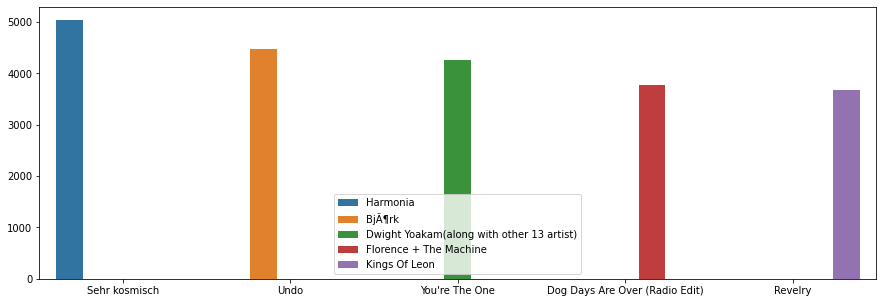

In [57]:
plt.figure(figsize=(15,5))
y = count_list
x = ['Sehr kosmisch','Undo',"You're The One",'Dog Days Are Over (Radio Edit)','Revelry']


sns.barplot(x = x,y = y,hue = top_5_songs_artist);

* The above graph shows the top 5 songs and their respective artists name

In [58]:
song_df

,user_id,song_id,freq,artist_name,release
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,Cartola,Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,Miguel Calo,El Cuatrero
...,...,...,...,...,...
1450928,5e650759ebf89012044c6d52121eeada8b0ec814,SOVLNXV12A6D4F706E,1,Mos Def,Ms. Fat Booty
1450929,5e650759ebf89012044c6d52121eeada8b0ec814,SOVDSJC12A58A7A271,2,Sam Cooke,Ain't Misbehavin
1450930,5e650759ebf89012044c6d52121eeada8b0ec814,SOBRHVR12A8C133F35,2,Southside Spinners,Luvstruck
1450931,5e650759ebf89012044c6d52121eeada8b0ec814,SOMGVYU12A8C1314FF,2,J. Karjalainen & Mustat Lasit,Sinisten tähtien alla


In [59]:
song_df[song_df['artist_name'] == 'Justin Bieber']['release'].unique()

array(['Down To Earth', 'One Time', 'U Smile', 'Favorite Girl', 'Love Me',
       'Common Denominator', 'Never Let You Go', 'Stuck In The Moment',
       'Up', 'One Less Lonely Girl', 'That Should Be Me', 'Bigger',
       'Runaway Love'], dtype=object)

In [60]:
song_df[song_df['release'] == 'Down To Earth']

,user_id,song_id,freq,artist_name,release
799,f6e34f0a68d5ea1344511e33486f956de361db78,SOFKFXC12AC90732A5,7,Justin Bieber,Down To Earth
5023,c48985d93d590dff33d20094eebc863b0cb455e8,SOFKFXC12AC90732A5,1,Justin Bieber,Down To Earth
7604,0011d5f4fb02ff276763d385c3f2ded2b00ad94a,SOFKFXC12AC90732A5,3,Justin Bieber,Down To Earth
10389,4d986dc5459157e2665eb50017f826973beaa46b,SOFKFXC12AC90732A5,1,Justin Bieber,Down To Earth
16679,6e4464ecd8c2b529626e556e3530c35b9ddd3cac,SOFKFXC12AC90732A5,2,Justin Bieber,Down To Earth
...,...,...,...,...,...
1429769,785e593ec8b1d60163a4961389ab4d5f502f44e5,SOFKFXC12AC90732A5,1,Justin Bieber,Down To Earth
1433057,2fc231bd85945993c1b97a7c74608d75e284b553,SOFKFXC12AC90732A5,2,Justin Bieber,Down To Earth
1439632,ce3fc8c8f35faab4b6595665e25e2a0c1a988833,SOFKFXC12AC90732A5,2,Justin Bieber,Down To Earth
1446535,20e4da491ef9c24c0cc68611abe24d1832bb15ba,SOFKFXC12AC90732A5,9,Justin Bieber,Down To Earth


In [61]:
sum(song_df['release'] == 'Down To Earth')

439

* the above shows that number of unique users for **release down to earth** by **justin bieber**

In [62]:
justin_songs = ['Down To Earth', 'One Time', 'U Smile', 'Favorite Girl', 'Love Me',
       'Common Denominator', 'Never Let You Go', 'Stuck In The Moment',
       'Up', 'One Less Lonely Girl', 'That Should Be Me', 'Bigger',
       'Runaway Love']
unique_users_count = []

for i in justin_songs:
    #print(i)
    unique_users_count.append(sum(song_df['release'] == i))
    


In [63]:
unique_users_count

[439, 767, 839, 278, 688, 248, 596, 422, 274, 578, 560, 228, 276]

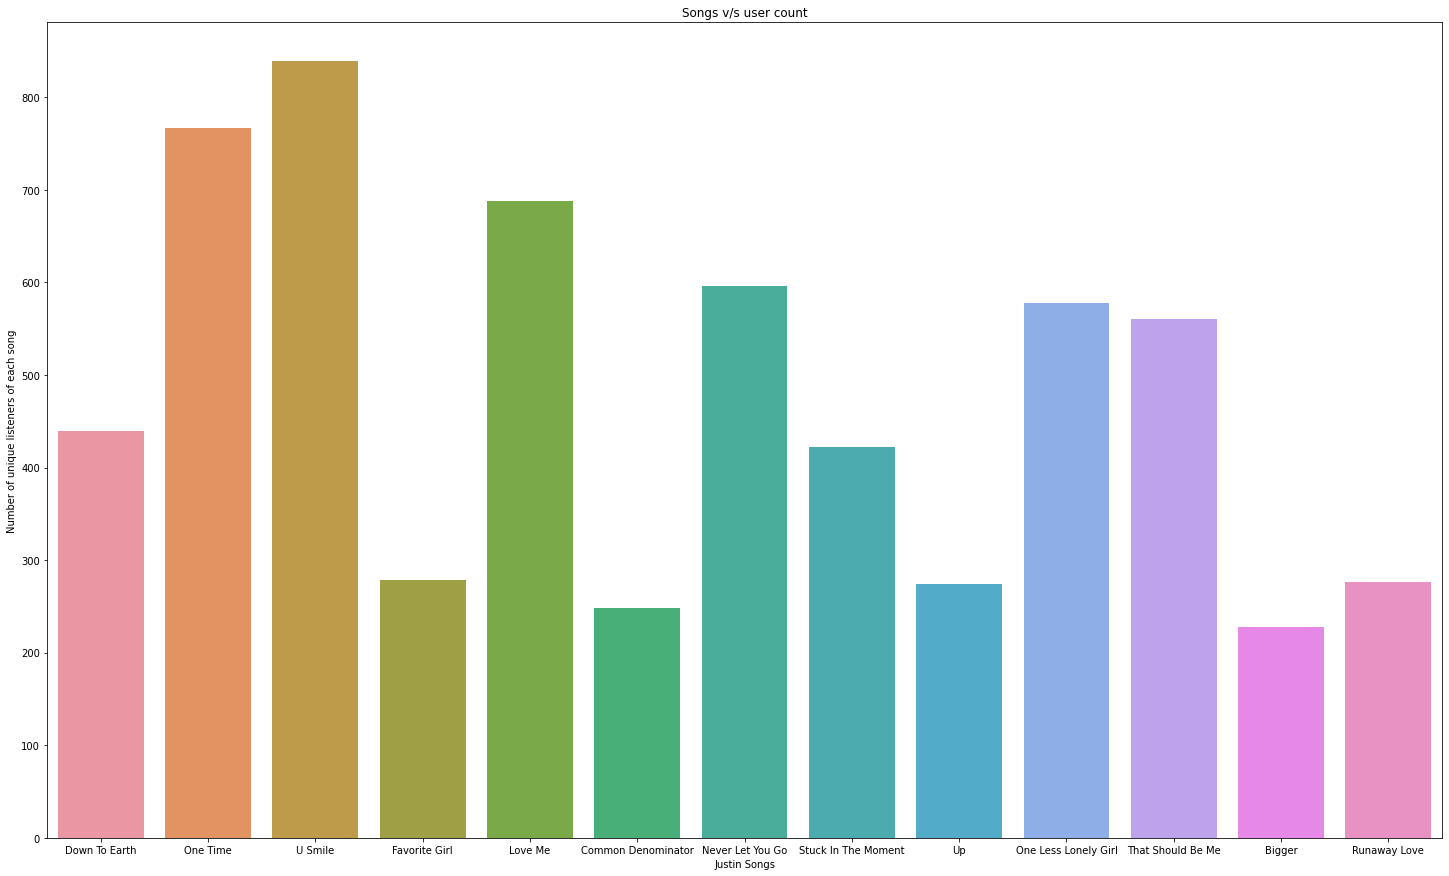

In [64]:
plt.figure(figsize=(25,15))
y = unique_users_count
x = justin_songs
plt.xlabel("Justin Songs")
plt.ylabel("Number of unique listeners of each song")

plt.title("Songs v/s user count")

sns.barplot(x = x,y = y);

* from above graph we observe that **U smile** song is most listened and **Bigger** song is least listened by the user 

# Artist analysis

In [65]:
song_df.head()

,user_id,song_id,freq,artist_name,release
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,Cartola,Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,Miguel Calo,El Cuatrero


In [66]:
artist_data = song_df[['artist_name','freq']]

In [67]:
artist_data.head()

,artist_name,freq
0,Dwight Yoakam,1
1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,1
2,Cartola,1
3,Lonnie Gordon,1
4,Miguel Calo,1


In [118]:
artist_data['artist_name'].value_counts()[0:5]

Coldplay                  10883
Florence + The Machine     8213
Train                      6617
The Black Keys             6507
Jack Johnson               6104
Name: artist_name, dtype: int64

In [119]:
artist_data['artist_name'].value_counts()[0:5].keys()

Index(['Coldplay', 'Florence + The Machine', 'Train', 'The Black Keys',
       'Jack Johnson'],
      dtype='object')

In [68]:
artist_aggr = artist_data.groupby('artist_name', as_index=False).sum()

In [69]:
artist_aggr.head()

,artist_name,freq
0,!!!,325
1,!Deladap,8
2,& And Oceans,9
3,'68 Comeback,49
4,'N Sync/Phil Collins,344


In [70]:
artist_aggr.shape

(28337, 2)

In [71]:
song_df['artist_name'].unique()

array(['Dwight Yoakam',
       'Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner',
       'Cartola', ..., 'P.Paul Fenech', 'Mystic Rhythms', 'H.e.a.t'],
      dtype=object)

In [72]:
song_df['artist_name'].nunique()

28337

# clustering on Artist data

In [73]:
from sklearn.cluster import KMeans
km1 = KMeans(n_clusters=10)


In [74]:
artist_count = artist_aggr[['freq']]

In [75]:
artist_count.head()

,freq
0,325
1,8
2,9
3,49
4,344


In [76]:
km1.fit(artist_count)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [77]:
label1= km1.labels_

In [78]:
label1

array([7, 0, 0, ..., 7, 0, 0], dtype=int32)

In [79]:
artist_aggr['cluster_id'] = label1

In [80]:
artist_aggr[artist_aggr['cluster_id']==3]

,artist_name,freq,cluster_id
120,3 Doors Down,11467,3
1287,Angels and Airwaves,9535,3
2304,Beastie Boys,10900,3
2558,Beyoncé,10842,3
2871,Black Eyed Peas,13706,3
4191,Cartola,10369,3
5356,Creedence Clearwater Revival,10613,3
5809,Daft Punk,13424,3
7961,Eminem,12448,3
8729,Five Iron Frenzy,10164,3


In [81]:
user_data = song_df[['user_id','freq']]

In [82]:
user_data.head()

,user_id,freq
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1


In [83]:
user_aggr = user_data.groupby('user_id', as_index=False).sum()

In [84]:
user_aggr.head()

,user_id,freq
0,00007a02388c208ea7176479f6ae06f8224355b3,13
1,00014a76ed063e1a749171a253bca9d9a0ff1782,24
2,00015189668691680bb1a2e58afde1541ec92ced,101
3,0001ff7aa2667c8d8b945317b88adaed1c0b9dc2,12
4,00020fcd8b01986a6a85b896ccde6c49f35142ad,44


In [85]:
user_aggr.shape

(110000, 2)

In [86]:
song_df.shape

(1450933, 5)

# clustering on user data

In [87]:
user_count = user_aggr[['freq']]

In [88]:
user_count.head()

,freq
0,13
1,24
2,101
3,12
4,44


In [89]:
km2 = KMeans(n_clusters=10)

In [90]:
km2.fit(user_count)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [91]:
label2 = km2.labels_

In [92]:
label2

array([4, 1, 2, ..., 2, 6, 7], dtype=int32)

In [93]:
user_aggr['cluster_id'] = label2

In [94]:
user_aggr[user_aggr['cluster_id']==3]

,user_id,freq,cluster_id
558,0138b1842d6e47baf4b789b4ea8fe461fc5ee869,334,3
735,01a62ddceb14b92e35db3c1c3deac2f26b7a2bd3,429,3
759,01b2e8ef63b0fe7916290c9c3f7fd6dab57983a7,420,3
1312,02f50f3698fbd3cdd9ae777d450f23b8f682eec5,322,3
1608,03b2c9d9d6ee9676e04ac6a3e130816c6edcd1bf,326,3
...,...,...,...
109017,fdc6937fc232398b9ef707cf0fcf0f1b5ba0baf8,429,3
109076,fde8a5aeb5df3d655256c8d0605f541eb2d36d52,349,3
109243,fe51720fdc60ead34b65ec4a5bdc094f0da46657,380,3
109293,fe6baffd1ecdb13956585ec1942bc28314dfda5e,457,3


In [95]:
song_df[song_df['artist_name'].isnull()]#checking whether the artist name is present or not

,user_id,song_id,freq,artist_name,release
73,c34670d9c1718361feb93068a853cead3c95b76a,SOEHWGF12A6D4F8B2B,3,NaN,NaN
101,fdf6afb5daefb42774617cf223475c6013969724,SOONUTJ12A6701D7B4,1,NaN,NaN
109,fdf6afb5daefb42774617cf223475c6013969724,SOPWKOX12A8C139D43,1,NaN,NaN
110,10cbcd627472477dfbec90fb75017f8df6ce84ec,SOTNWCI12AAF3B2028,1,NaN,NaN
122,e9dc6b4c2b22aa6dc8260e1963021567728055b2,SOPXKYD12A6D4FA876,6,NaN,NaN
...,...,...,...,...,...
1450745,153832123c017bcdb1e55a9bec1eefcabd8bb2d1,SOQUJLT12A8C141F8A,3,NaN,NaN
1450749,ada735bfc101da8cf65ce71615138c3e08ea0e88,SOTSLEU12A6D4F8639,4,NaN,NaN
1450805,987b654b09b239f7c47751e0cfaa2990834cbb55,SODWYJZ12AB018240F,3,NaN,NaN
1450829,6b6d43eb0a1a6bdf471cebe380524946884746c6,SOUAUMW12A8C140570,1,NaN,NaN


In [96]:
if song_df['artist_name'].isnull().sum() > 0:
    song_df = song_df.dropna(axis = 0, subset = ['artist_name'])#removing the data whose artist name has nan

In [97]:
song_df[song_df['artist_name'].isnull()]#checking the artist name has nan  after removing some rows 

,user_id,song_id,freq,artist_name,release


In [98]:
artist_plays = (song_df.
     groupby(by = ['artist_name'])['freq'].
     sum().
     reset_index().
    rename(columns = {'freq': 'total_artist_plays'})
     [['artist_name', 'total_artist_plays']])
artist_plays.head()

,artist_name,total_artist_plays
0,!!!,325
1,!Deladap,8
2,& And Oceans,9
3,'68 Comeback,49
4,'N Sync/Phil Collins,344


In [99]:
artist_plays['artist_name']

0                         !!!
1                    !Deladap
2                & And Oceans
3                '68 Comeback
4        'N Sync/Phil Collins
                 ...         
28332            Étienne Daho
28333                     Íon
28334          Ólafur Arnalds
28335             Órla Fallon
28336             Özlem Tekin
Name: artist_name, Length: 28337, dtype: object

In [100]:
artist_plays[artist_plays['artist_name']=="!Deladap"]

,artist_name,total_artist_plays
1,!Deladap,8


In [101]:
user_data_with_artist_plays = song_df.merge(artist_plays, left_on = 'artist_name', right_on = 'artist_name', how = 'left')
user_data_with_artist_plays.head()#out of 35688 fd50c4007b68a3737fe052d5a4f78ce8aa117f3d user has listened for only once

,user_id,song_id,freq,artist_name,release,total_artist_plays
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One,35688
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,17124
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,Cartola,Tive Sim,10369
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,10585
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,Miguel Calo,El Cuatrero,737


In [102]:
artist_plays['total_artist_plays'].describe()

count    28337.000000
mean       159.171507
std        789.327789
min          1.000000
25%          4.000000
50%         17.000000
75%         77.000000
max      35688.000000
Name: total_artist_plays, dtype: float64

In [103]:
artist_plays['total_artist_plays'].max()

35688

In [104]:
artist_plays[artist_plays['total_artist_plays']==artist_plays['total_artist_plays'].max()]

,artist_name,total_artist_plays
7428,Dwight Yoakam,35688


In [105]:
artist_plays['total_artist_plays'].value_counts()

1       3400
2       1865
3       1249
5       1017
4        984
        ... 
1576       1
1528       1
1480       1
3497       1
6147       1
Name: total_artist_plays, Length: 1609, dtype: int64

In [106]:
popularity_threshold = 30000
user_data_popular_artists = user_data_with_artist_plays.query('total_artist_plays >= @popularity_threshold')
user_data_popular_artists.head()

,user_id,song_id,freq,artist_name,release,total_artist_plays
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One,35688
73,c34670d9c1718361feb93068a853cead3c95b76a,SOAUWYT12A81C206F1,1,Björk,Undo,35210
76,c34670d9c1718361feb93068a853cead3c95b76a,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One,35688
251,4b9b549e84fb29bfbcf7ab34f01c0bcd1bbf93a5,SOAUWYT12A81C206F1,1,Björk,Undo,35210
294,c5006d9f41f68ccccbf5ee29212b6af494110c5e,SOBONKR12A58A7A7E0,1,Dwight Yoakam,You're The One,35688


In [107]:
song_df['freq'].max()

923

In [108]:
user_data_with_artist_plays.query('freq>500')

,user_id,song_id,freq,artist_name,release,total_artist_plays
354284,9d12c30de5d9975f621f95f512699989ac544410,SOFFXAQ12A8AE45C2E,535,Fear My Thoughts,Death Chamber,753
458494,2d9ea6058d0872ccdc5b1c5c685758bb9c55f0a3,SOAOXTG12A67021AA7,597,Ms. Dynamite / Kymani Marley,Seed Will Grow,784
625391,a86e68128c6a48d3392db22ce1151a3bdccf5fcf,SOFVLYV12A8C145D8F,537,Us3,Believe In Yourself,834
815937,a1cc4d088600df2db42e6a305974675ffe8c905d,SOPMHHE12AB01845F6,646,The Beach Boys,What Is a Young Girl Made of,1931
1262911,69ad6b6a1d14d740eb8c2f013a19c1f8048cecde,SONGOJV12AF729AEBD,582,Queen,Somebody To Love,4214
1410202,22bb29714137fa47083963c30e1a26f1bf517e7d,SOXTUWG12AB018A2E2,923,Kilgore,Drop The Hammer (Album Version),924


# sparse matrix